In [1]:
from iminuit import Minuit
import matplotlib.pyplot as plt
from matplotlib import transforms
from matplotlib import rc
from IPython.display import Image
import numpy as np
from astropy.io import fits as pyfits
from astropy.io import fits
from scipy.ndimage import gaussian_filter
import scipy
from scipy.optimize import minimize, rosen, rosen_der
from scipy.special import factorial
import scipy.integrate as integrate
from scipy.integrate import quad
from itertools import starmap
from scipy import optimize
import corner
import time
from mpl_toolkits import mplot3d
import healpy as hp
from scipy import nan
import dark_matter_jfactors as dmj
import math
import random
import importlib
from pymultinest.solve import solve
import pymultinest
import warnings
warnings.filterwarnings("ignore")
import scipy as sp
import scipy.interpolate
import json
from os import walk
import re

In [2]:
filelist = ['Bremss_00320087_E_50-814008_MeV_healpix_128.fits', 'Bremss_SL_Z6_R20_T100000_C5_E_50-814008_MeV_healpix_128.fits', 'pi0_Model_A_E_50-814008_MeV_healpix_128.fits', 'pi0_Model_F_E_50-814008_MeV_healpix_128.fits', 'ICS_Model_A_E_50-814008_MeV_healpix_128.fits', 'ICS_Model_F_E_50-814008_MeV_healpix_128.fits']
evermore_shifted = np.asarray([
    [33, 21, 49],
    [154, 112, 82],
    [241, 149, 91],
    [142, 52, 38],
    [33, 21, 49],
])/256

#exposure_time = 4.1e6 #.13 years 47 days
#exposure_time = 4.1e8 #13 years
#exposure_time = 4.1e9 #130 years
#exposure_time = 4.1e11 #13000 years
exposure_time = 4.1e13 #1 billion years
#exposure_time = 3.154e10


In [3]:


def log_interp1d(xx, yy, kind='linear'):
    logx = np.log10(xx)
    logy = np.log10(yy)
    lin_interp = sp.interpolate.interp1d(logx, logy, kind=kind, fill_value="extrapolate")
    log_interp = lambda zz: np.power(10.0, lin_interp(np.log10(zz)))
    return log_interp

def get_all_egb_data(energies, deltae):
    energy_range = np.array([(.1, .14), (.14, .2), (.2, .28), (.28, .4), (.4, .57), (.57, .8), (.8, 1.1), (1.1, 1.6), (1.6, 2.3), (2.3, 3.2), (3.2, 4.5), (4.5, 6.4), (6.4, 9.1), (9.1, 13), (13, 18), (18, 26), (26, 36), (36, 51), (51, 72), (72, 100), (100, 140), (140, 200), (200, 290), (290, 410), (410, 580), (580, 820)])*1e3 #GeV to MeV
    egb_intensity = np.array([3.7e-6, 2.3e-6, 1.5e-6, 9.7e-7, 6.7e-7, 4.9e-7, 3e-7, 1.8e-7, 1.1e-7, 6.9e-8, 4.2e-8, 2.6e-8, 1.7e-8, 1.2e-8, 6.8e-9, 4.4e-9, 2.7e-9, 1.8e-9, 1.1e-9, 6.2e-10, 3.1e-10, 1.9e-10, 8.9e-11, 6.3e-11, 2.1e-11, 9.7e-12])
    middle_bin = []
    bin_width = []
    for i in range(0, len(energy_range)):
        low_e = np.log10(energy_range[i][0])
        high_e = np.log10(energy_range[i][1])
        difference = np.abs((low_e+high_e)/2)
        middle_bin.append(10**(difference))
        bin_width.append(np.abs(energy_range[i][1]-(10**(difference)))) 
    return middle_bin, bin_width, egb_intensity

def get_all_egb(energies, deltae):
    energy_range = np.array([(.1, .14), (.14, .2), (.2, .28), (.28, .4), (.4, .57), (.57, .8), (.8, 1.1), (1.1, 1.6), (1.6, 2.3), (2.3, 3.2), (3.2, 4.5), (4.5, 6.4), (6.4, 9.1), (9.1, 13), (13, 18), (18, 26), (26, 36), (36, 51), (51, 72), (72, 100), (100, 140), (140, 200), (200, 290), (290, 410), (410, 580), (580, 820)])*1e3 #GeV to MeV
    egb_intensity = np.array([3.7e-6, 2.3e-6, 1.5e-6, 9.7e-7, 6.7e-7, 4.9e-7, 3e-7, 1.8e-7, 1.1e-7, 6.9e-8, 4.2e-8, 2.6e-8, 1.7e-8, 1.2e-8, 6.8e-9, 4.4e-9, 2.7e-9, 1.8e-9, 1.1e-9, 6.2e-10, 3.1e-10, 1.9e-10, 8.9e-11, 6.3e-11, 2.1e-11, 9.7e-12])
    middle_bin = []
    bin_width = []
    for i in range(0, len(energy_range)):
        low_e = np.log10(energy_range[i][0])
        high_e = np.log10(energy_range[i][1])
        difference = np.abs((low_e+high_e)/2)
        middle_bin.append(10**(difference))
        bin_width.append(np.abs(energy_range[i][1]-(10**(difference)))) 
        

    log_interp = log_interp1d(middle_bin, egb_intensity/bin_width, kind='linear')
    
    '''
    print(egb_intensity[2]/bin_width[2]*deltae[6])
    print(energies[6])
    x_trapz = np.logspace(np.log10(np.nanmin(energies)), np.log10(np.nanmax(energies)), num = 100)
    plt.scatter(middle_bin, egb_intensity/bin_width)
    plt.plot(x_trapz, log_interp(x_trapz), color = 'red')
    plt.scatter(energies[6], log_interp(energies[6]), color = 'green')
    plt.yscale('log')
    plt.xscale('log')
    '''
    
    counts = []
    #only want energies from 3 onward (about lowest at 80 MeV)
    for x in range(3, len(energies)):
        highest_val = energies[x]+deltae[x]
        lowest_val = energies[x]-deltae[x]
        x_trapz = np.logspace(np.log10(lowest_val), np.log10(highest_val), num = 400)
        #counts.append(log_interp(energies[x])*deltae[x])
        total_counts = np.trapz(log_interp(x_trapz), x = x_trapz)
        
        #print('total counts: {}'.format(total_counts))
        '''
        plt.scatter(middle_bin, egb_intensity/bin_width)
        plt.plot(x_trapz, log_interp(x_trapz), color = 'red')
        plt.scatter(energies[x], total_counts)
        
        plt.yscale('log')
        plt.xscale('log')
        asdfads
        '''
        counts.append(total_counts)  
    return counts #returns counts per cm^2 per sec per str


In [4]:
def readfile(filename):
    """
    A simple function to read the maps of a given number n and given filename.
    """
    file_to_read = fits.open(filename)
    return file_to_read

def reshape_file(hdu, n, inner20 = True):
    """
    Reshapes the data to be in the size we want
    """
    
    if inner20:
        numpix = np.linspace(0, hdu[0].header['NPIX']-1, num = hdu[0].header['NPIX'])
        NSIDE = int(hdu[0].header['NSIDE'])
        degrees = hp.pix2ang(NSIDE, np.array(numpix,dtype=np.int), lonlat = True)
        inner_20_pos = np.where(np.sqrt((degrees[0])**2+degrees[1]**2)<= 20)
        inner_20_neg = np.where(np.sqrt((degrees[0]-360)**2+degrees[1]**2)<= 20)
        testbin = list(hdu[n].data[inner_20_pos])+list(hdu[n].data[inner_20_neg])
        
        #might need this for plotting, not sure
        #data4 = hdu[n].data
        #test20 = np.copy(data4)
        #test20[inner_20] = np.nan
        #testbin = np.reshape(test20, (128*3, 1536//3))

    else:
        """
        testbin = np.reshape(hdu[n].data, (128*3, 1536//3))
        
        """
        numpix = np.linspace(0, hdu[0].header['NPIX']-1, num = hdu[0].header['NPIX'])
        NSIDE = int(hdu[0].header['NSIDE'])
        degrees = hp.pix2ang(NSIDE, np.array(numpix,dtype=np.int), lonlat = True)
        
        inner_20_pos = (np.sqrt((degrees[0])**2+degrees[1]**2)> 20)
        inner_20_neg = (np.sqrt((degrees[0]-360)**2+degrees[1]**2)> 20)
        inner_20 = np.logical_and(inner_20_pos, inner_20_neg)
        
        data4 = hdu[n].data
        test20 = np.copy(data4)
        #test20[inner_20] = np.nan
        #print(sum(~np.isnan(test20)))
        testbin = np.reshape(test20, (128*3, 1536//3))
        
    return testbin

def get_energy_index(E_desired, hdu):
    energy_hdu = np.concatenate(hdu[38].data, axis = 0)
    idx = find_nearest(energy_hdu, E_desired)
    return idx
    
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
    

In [5]:
def subtract(n):
    ##Template for 1 GeV and 10 GeV
    icsa = readfile(filelist[n])
    
    idx1 = get_energy_index(1*1e3, icsa)
    idx10 = get_energy_index(10*1e3, icsa)
    
    array1 = reshape_file(icsa, idx1, inner20 = False)
    array10 = reshape_file(icsa, idx10, inner20 = False)
    
    ##Sum up idx1 and idx 10, make them equal in sum
    sum1 = np.nansum(array1)
    sum10 = np.nansum(array10)
    array10_adjusted = (array10*sum1/sum10)
    subtract110 = np.abs(array1-array10_adjusted)/array1
    fig, ax = plt.subplots(figsize=(10, 10))
    image = ax.imshow(subtract110)
    fig.colorbar(image, ax=ax, anchor=(0, 0.3), shrink=0.7)
    plt.title(str(filelist[n]))
    
    return

In [6]:


#n = 4 for ICSA, n = 2 for pi0
def psf_smoothing(n, energyidx, inner20psf = False):
    icsa = readfile(filelist[n])

    inner20psf = False
    
    data50 = reshape_file(icsa, energyidx, inner20 = inner20psf) #get the data at 50 MeV
    

    
    #data50_convolved = gaussian_filter(data50, sigma=0) #PSF off
    data50_convolved = np.copy(data50)
    
    
    hdu = readfile(filelist[n])
    numpix = np.linspace(0, hdu[0].header['NPIX']-1, num = hdu[0].header['NPIX'])
    NSIDE = int(hdu[0].header['NSIDE'])
    
    data50_convolved = data50_convolved.flatten()

    degrees = hp.pix2ang(NSIDE, np.array(numpix,dtype=np.int), lonlat = True)
    inner_20_pos = np.where(np.sqrt((degrees[0])**2+degrees[1]**2)<= 20)
    inner_20_neg = np.where(np.sqrt((degrees[0]-360)**2+degrees[1]**2)<= 20)
    inner_20_pos_forsum = np.argwhere(np.sqrt((degrees[0])**2+degrees[1]**2)<= 20)
    inner_20_neg_forsum = np.argwhere(np.sqrt((degrees[0]-360)**2+degrees[1]**2)<= 20)
    inner_20_true_pos = (np.sqrt((degrees[0])**2+degrees[1]**2)> 20)
    inner_20_true_neg = (np.sqrt((degrees[0]-360)**2+degrees[1]**2)> 20)
    inner_20 = np.logical_and(inner_20_true_pos, inner_20_true_neg)
    
    initsum = np.nansum(list(data50.flatten()[inner_20_pos_forsum]) + list(data50.flatten()[inner_20_neg_forsum]))
    
    data50_convolved[inner_20] = np.nan
    plotimage = np.reshape(data50_convolved, (128*3, 1536//3))
    #plt.imshow(np.log10(plotimage))
    #plt.show()
    #plt.close()
    
    testbin = list(data50_convolved[inner_20_pos])+list(data50_convolved[inner_20_neg])
    finsum = np.nansum(testbin)

    return np.array(testbin)*initsum/finsum

def psf_smoothing_DM(energyidx, crosssec = 2.2e-26, anal_data = False, mass_dm = 100):
    energybin = np.concatenate(readfile(filelist[0])[38].data, axis = 0)[energyidx]
    bins_in_lin = np.log10(energybin)
    deltae = get_deltaE(energyidx)
    
    highe = (energybin+deltae)/1e3
    lowe = (energybin-deltae)/1e3
    
    hdu = readfile(filelist[0])
    numpix = np.linspace(0, hdu[0].header['NPIX']-1, num = hdu[0].header['NPIX'])
    NSIDE = int(hdu[0].header['NSIDE'])
    
    degrees = hp.pix2ang(NSIDE, np.array(numpix,dtype=np.int), lonlat = True)
    inner_20_pos = np.where(np.sqrt((degrees[0])**2+degrees[1]**2)<= 20)
    inner_20_neg = np.where(np.sqrt((degrees[0]-360)**2+degrees[1]**2)<= 20)
    inner_20_pos_forsum = np.argwhere(np.sqrt((degrees[0])**2+degrees[1]**2)<= 20)
    inner_20_neg_forsum = np.argwhere(np.sqrt((degrees[0]-360)**2+degrees[1]**2)<= 20)
    inner_20_true_pos = (np.sqrt((degrees[0])**2+degrees[1]**2)> 20)
    inner_20_true_neg = (np.sqrt((degrees[0]-360)**2+degrees[1]**2)> 20)
    inner_20 = np.logical_and(inner_20_true_pos, inner_20_true_neg)
    
    
    #need to make sure the initsum is *only within the inner 20 degrees, same for finsum
    data50 = dmj.get_dNdE(highe, lowe, sigmav = crosssec, analyze_data = anal_data, massx = mass_dm)[1] #photons per cm^2 per sec per str per MeV
    

    
    initsum = np.nansum(list(data50.flatten()[inner_20_pos_forsum]) + list(data50.flatten()[inner_20_neg_forsum]))
    data50_convolved = np.copy(data50)
    #data50_convolved = gaussian_filter(data50, sigma=0) #psf off
    data50_convolved = data50_convolved.flatten()
    data50_convolved[inner_20] = np.nan
    plotimage = np.reshape(data50_convolved, (128*3, 1536//3))
    #plt.imshow(np.log10(plotimage))
    #plt.show()
    #plt.close()


    testbin = list(data50_convolved[inner_20_pos])+list(data50_convolved[inner_20_neg])
    finsum = np.nansum(testbin) #photons per cm^2 per sec per str per MeV
    
    return np.array(testbin)*initsum/finsum

def poisson_dist(n, energyidx, cross_section =2.2e-26, dm = False, analyze_data = False, dm_mass = 100, egb = False, counts = 0):   
    '''
    Performs a PSF smoothing of the array, before converting it into photons per pixel
    
    '''
    deltaE = get_deltaE(energyidx)
    if dm:
        convolved_data = psf_smoothing_DM(energyidx, cross_section, anal_data = analyze_data, mass_dm = dm_mass)/deltaE
    elif egb:
        convolved_data_init = np.empty(5910)
        convolved_data_init.fill(1)
        convolved_data = convolved_data_init*counts #in units of photons per cm^2 per mev per str per sec
    else:
        convolved_data = psf_smoothing(n, energyidx, cross_section) #data in units of photons cm^-2 MeV^-1 str^-1
    deltaomega = 4*np.pi/196608 #divide by num of pixels
    n_gamma = np.array(convolved_data)*deltaE*exposure_time*8500*deltaomega*.2 #13 years*.85meters^2, units of photons per pixel
    
    return n_gamma

def get_deltaE(n):
    energybins = np.concatenate(readfile(filelist[0])[38].data, axis = 0)
    bins_in_lin = np.log10(energybins)[n]
    spacing = 0.05691431
    
    high_bin = 10**(bins_in_lin + spacing)
    low_bin = 10**(bins_in_lin - spacing)
    
    deltaE = np.abs(high_bin - low_bin)
    #print('delta E: {}'.format(deltaE))
    
    return deltaE

def get_image(data):
    fig, ax = plt.subplots(figsize=(10, 10))
    image = ax.imshow(data)
    fig.colorbar(image, ax=ax, anchor=(0, 0.3), shrink=0.7)
    return

def simulated_data(energyidx, templates):
    
    '''
    Use PSF smoothed data to create a random poisson draw to obtain simulated data
    '''
    
    
    n_gammatot = 0
    for i in range(0, len(templates)):
        n_gammatot += templates[i]
    len_of_rand = len(n_gammatot)
    simdata = np.zeros(len_of_rand)
    randdata = np.random.rand(len_of_rand)
    
    for i in range(0, len_of_rand):
        #print(n_gammatot[i])
        if n_gammatot[i]<.01:
            if n_gammatot[i] < randdata[i]:
                simdata[i] = 0
            else:
                simdata[i] = 1
        else:
            simdata[i] = np.random.poisson(lam = n_gammatot[i])
    #print('simdata just 20: ', np.nansum(simdata))
    
    return simdata

def minimize_likelihood(energyidx, cross_sec = 2.2e-26, massdm = 100):
    pi = poisson_dist(2, energyidx)
    ics = poisson_dist(4, energyidx)   
    brem = poisson_dist(0, energyidx)

    darkm = poisson_dist(np.nan, energyidx, cross_section = cross_sec, dm = True, dm_mass = massdm)

    k = simulated_data(energyidx, [pi, ics, brem])#remove DM for accurate
    #print(np.nanmean(lamb))
    #asdfasd
    
    #Need to minimize for lamb < 50 and lamb > 50
    
    bnds = ((0, np.inf), (0, np.inf), (0, np.inf), (1e-30, np.inf))
    result = minimize(likelihood, (1, 1, 1, 1), args = (k, pi, ics, brem, darkm), bounds = bnds)
    min_likelihood = result.x
    chi2 = result.fun
    #print(result)

    return min_likelihood


def likelihood(constants, k, pi, ics, brem, dm):
    """
    Gets the Total Likelihoods from the Gaussian Regime and the Poisson Regime
    Once each has been calculated, multiplies values together for final likelihood
    """
    
    likelihood_poiss = likelihood_poisson(constants, k, pi, ics, brem, dm)
    #print('likelihood: {}'.format(likelihood_poiss)) 
    return likelihood_poiss

def merge(list1, list2):
      
    merged_list = tuple(zip(list1, list2)) 
    return merged_list

def likelihood_gaussian(constants, lamb, pi, ics):
    sigma = np.sqrt(constants[0]*pi+constants[1]*ics)
    mu = lamb
    rng = 0.5
    
    #flatten arrays
    sigma_flat = sigma.flatten()
    mu_flat = mu.flatten()
    length_flattened = len(mu_flat)
    #get arrays in sigma, mu tuple format
    ms_tuples = list(merge(mu_flat, sigma_flat))
    ms = np.array(ms_tuples, dtype = 'f,f')
    lower_bound_arr = mu_flat - rng
    upper_bound_arr = mu_flat + rng
    
    args = np.concatenate((np.full((length_flattened, 1), prob_func), lower_bound_arr.reshape((length_flattened, 1)), upper_bound_arr.reshape((length_flattened, 1)), ms.reshape((length_flattened, 1))), axis = 1)
    
    #log likelihood
    prob = list(starmap(lambda a, b, c, d: quad(a, b, c, d)[0], args))

    #reshape for testing
    l = np.sum(np.log(prob))
    likely = -2*l
    
    return likely
    
def prob_func(x, mu, sigma):
    probdens = 1/(sigma*np.sqrt(2*np.pi))*np.exp(-1/2*((x-sigma**2)/sigma)**2)
    return probdens

#def likelihood_poisson(a0):
def likelihood_poisson(a0, a1, a2, a3, a4):
#def likelihood_poisson(constants, ktest, pitest, icstest, bremtest, dmtest):
    lamb = a0*pitest+a1*icstest+a2*bremtest+a3*darkmtest+a4*egbtest
    #lamb = a0*egbtest
    
    #print(a0, a1, a2, a3)
    #print(lamb)

    #lamb = constants[0]*pitest+constants[1]*icstest+constants[2]*bremtest+constants[3]*dmtest
    
    fprob = -scipy.special.gammaln(ktest+1)+ktest*np.log(lamb)-lamb #log likelihood of poisson
    #print(fprob)
    return -2*np.nansum(fprob)

def get_curves(n, energyidx, inner20psf = True):
    icsa = readfile(filelist[n])
    data50 = reshape_file(icsa, energyidx, inner20 = inner20psf) #get the data at energyidx MeV
    delt = get_deltaE(energyidx)
    return np.asarray(data50)*exposure_time*8500*.2*delt #13 years * .85 m^2 * .2, return in photons /str
    
def get_normalizations_spectrum(deltaE, cross_sec = 2.2e-26, dm_mass = 100):
    
    range_templates = [2, 4, 0] #pi, ics, brem
    e = readfile(filelist[0])[38].data
    energies = np.array(list(e)).T[0]
    templates = []
    temp = []
    deltaomega = 4*np.pi/196608 #i think this should maybe still be total bins in whole image pre-20?

    
    for n in range_templates:
        temp = []
        for index in range(3, len(energies)):
            temp.append(np.nansum(get_curves(n, index))) #units of photons per str
        templates.append(np.asarray(temp)*deltaomega) #gets counts per bin
    
    '''
    #dark matter template
    
    dm_temp = []
    dm_templates_tot = []
    for index in range(3, len(energies)):
        energybin = np.concatenate(readfile(filelist[0])[38].data, axis = 0)[index]
        bins_in_lin = np.log10(energybin)
        deltae = get_deltaE(index)
    
        highe = (energybin+deltae)/1e3
        lowe = (energybin-deltae)/1e3
        data50 = dmj.get_dNdE(highe, lowe, sigmav = cross_sec, massx = dm_mass, for_normals = True)[1] #units of photons cm^-2 str^-1 per sec not per MeV?
        #need to cut this to be inner 20 degrees
        
        
        #dm_temp.append(np.nansum(data50))
        dm_temp.append(np.nansum(data50)*exposure_time*8500) #13 years * .85 m^2 * .2, return in photons/str
    dm_templates_tot.append(np.asarray(dm_temp)*deltaomega) #photons per pixel?
    #print(np.nansum(dm_templates_tot[0]))

    #EGB template
    egb_templates = np.array(get_all_egb(energies, deltaE)) #units of counts per cm^2 per sec per str
    egb_temp_fin = egb_templates*8500*exposure_time*deltaomega #counts per bin
    '''
    
    return range_templates, energies, [np.array(templates[0])*.2, np.array(templates[1])*.2, np.array(templates[2])*.2]
    #return range_templates, energies, [np.array(templates[0])*.2, np.array(templates[1])*.2, np.array(templates[2])*.2, np.array(dm_templates_tot)*.2, np.array(egb_temp_fin)*.2] #counts per pixel
    
    
def get_normalized(energyidx, normals, template_val, energies):
    '''
    Normalizes the ROI based on the shape the spectrums should have
    
    
    Do not need to use this, as long as you stay consistent across all Fermi data
    for the exposure time and collecting area
    
    '''
    
    poisson_pi = poisson_dist(template_val, int(energyidx)) #units of photons per pixel
    init_sum_pi = np.nansum(poisson_pi)
    #print(np.nansum(init_sum_pi))
    if template_val == 2:
        normval = 0
    if template_val == 4:
        normval = 1
    if template_val == 0:
        normval = 2
    print('normval for pi at 0: {}'.format(normals[normval][energyidx])) 
    print('delta E at 0: {}'.format(get_deltaE(energyidx)))
    normal_pi = normals[normval][energyidx]*get_deltaE(energyidx)
    pitest = poisson_pi*normal_pi/init_sum_pi
    print('normalization: {}'.format(np.nansum(pitest)))
    #print(np.nansum(pitest))
    
    #print('----------------------')
    
    return pitest
    

In [7]:


def get_darksusy_counts():
    x = np.loadtxt('yield_DS_keith100.dat', dtype=str).T
    energies = x[1].astype(np.float)*1e3
    yieldperann = x[2].astype(np.float)/1e3 #convert from per GeV to per MeV
    energybins = np.concatenate(readfile(filelist[0])[38].data, axis = 0)
    
    counts = []
    delta = []
    for n in range(0, 38):
        
        bins_in_lin = energybins[n]
        deltae = get_deltaE(n)
    
        highe = (bins_in_lin+deltae)
        lowe = (bins_in_lin-deltae)
        
        good_energies = np.where((energies <=highe) & (energies >= lowe))
        
        final_integral = np.trapz(yieldperann[good_energies], x = energies[good_energies])

        counts.append(final_integral)
        delta.append(deltae)
    return np.array(counts), np.array(delta)



In [8]:
#start by testing egb I suppose

importlib.reload(dmj)
#gets darksusy counts for a specific dark matter mass
counts, deltae = get_darksusy_counts()
#be sure to change the dm mass
temps, energies, normals = get_normalizations_spectrum(deltae, cross_sec = 2.2e-26)


In [ ]:
#main chunk of code now
#testing pymultinest



#code that returns the log-likelihood at a specific point. cube is first parameter, everything else are random parameters
#that are not part of the fitting cube
def likelihood_poisson_multinest(cube, pitest, icstest, bremtest, ktest):
    a0 = 10**cube[0]
    a1 = 10**cube[1]
    a2 = 10**cube[2]
    #a3 = 10**cube[3]
    #a4 = 10**cube[4]
    lamb = a0*pitest+a1*icstest+a2*bremtest#+a3*darkmtest+a4*egbtest
    #lamb = a0*egbtest+a1*darkmtest+a2*bremtest#
    #lamb = a0*darkmtest
    #lamb = a0*pitest+a1*icstest+a2*bremtest+a3*darkmtest+a4*egbtest
    fprob = -scipy.special.gammaln(ktest+1)+ktest*np.log(lamb)-lamb #log likelihood of poisson
    return -2*np.nansum(fprob) #perhaps add negative back, perhaps add 2 back?

##This is the prior function, it is flat in linear space, from a minimum value specified by the first number, 
#to a maximum number specified by the first number + the second number. 
#The variables were called a/b/c/phi0/phi1/norm in this code.
#You need to define a prior for every parameter you send

def prior(cube, ndim, nparams):
    cube[0] = (cube[0]*14 - 8) #from 1e-4 to 1e4 apparently
    cube[1] = (cube[1]*14 - 8)
    cube[2] = (cube[2]*14 - 8)
    #cube[3] = (cube[3]*14 - 8)
    #cube[4] = (cube[4]*14 - 8)
    #cube[4] = (cube[4]*8 - 4)
    return cube

##This is the loglikelihood function for multinest – it sends the cube,
#and then a bunch of different arrays that were used in fitting, but were constant, to the pymultinest code
def loglikelihood_formulti(cube, ndim, nparms):
    return likelihood_poisson_multinest(cube, pitest, icstest, bremtest, ktest)
    #return likelihood_poisson_multinest(cube, pitest, icstest, bremtest, darkmtest, egbtest, ktest)
    

#getting errors and stuff for the dark matter stuff
e = readfile(filelist[0])[38].data
energies = np.array(list(e)).T[0]
#cross_sec normalized to 2.2e-26
points = []
errors = []
values = []
fluxes = []
deltae_cut = np.copy(deltae[3:])


#EGB getting now, first get all the counts at each energy bin
egb_counts = get_all_egb(energies, deltae)/deltae_cut #units of counts per cm^2 per sec per str per MeV
counting = 0

##These are the names of the parameters we are fitting.
#parameters = ['a0', 'a1', 'a2', 'a3', 'a4']
#parameters = ['a0', 'a1']
parameters = ['a0', 'a1', 'a2']
#parameters = ['a0']

folder = './pymultinest_chains/'
livepoints = 200

'''Check if directory exists, if not, create it'''
import os

# You should change 'test' to your preferred folder.
MYDIR1 = (folder + "negative")
CHECK_FOLDER = os.path.isdir(MYDIR1)

# If folder doesn't exist, then create it.
if not CHECK_FOLDER:
    os.makedirs(MYDIR1)
    print("created folder : ", MYDIR1)

else:
    print(MYDIR1, "folder already exists.")

#getting the constants in front of the poission dist. arrays
for energyidx in range(3, len(energies)):
#for energyidx in range(3, 7):
    # You should change 'test' to your preferred folder.
    MYDIR = (MYDIR1 + "/chain" + str(energyidx))
    CHECK_FOLDER = os.path.isdir(MYDIR)

    # If folder doesn't exist, then create it.
    if not CHECK_FOLDER:
        os.makedirs(MYDIR)
        print("created folder : ", MYDIR)

    else:
        print(MYDIR, "folder already exists.")
    print(energyidx, energies[energyidx])
    
    start_time = time.time()
    pitest = poisson_dist(2, int(energyidx))
    icstest = poisson_dist(4, int(energyidx))
    bremtest = poisson_dist(0, int(energyidx))
    print("--- %s seconds to get base templates---" % (time.time() - start_time))
    


    #EGB counts, we have at each energy bin in units of per cm^2 per s per str per MeV
    #egbtest = poisson_dist(np.nan, int(energyidx), egb = True, counts = egb_counts[counting])

    #importlib.reload(dmj) 
    #darkmtest = poisson_dist(np.nan, int(energyidx), dm = True, cross_section = 2.2e-26, analyze_data = False)

    #darkmtest[np.isnan(darkmtest)] = 0
    
    

    #gotta add egbtest to the ktest
    

    start_time = time.time()
    ktest = simulated_data(int(energyidx), [pitest, icstest, bremtest])
    #ktest = simulated_data(int(energyidx), [pitest, icstest, bremtest])
    print("--- %s seconds to get ktest---" % (time.time() - start_time))
    
    ##This is the main part of the code – it tells pymultinest to run loglikelihood in a loop – 
    #with 6 variables defined in the prior function, and send the output to the folder we specified.
    #N_live_points tells you how many different chains to test (usually 200-1000)
    ##json.dump (requires import json) saves the output into a parameters file.
    #result = solve(LogLikelihood=likelihood_poisson_multinest, Prior=prior, n_dims=int(len(parameters)), outputfiles_basename=folder+"/params", verbose=True)
    
    start_time = time.time()
    finals = pymultinest.run(loglikelihood_formulti, prior, int(len(parameters)), outputfiles_basename=MYDIR+"/"+ str(energyidx), n_live_points=livepoints, resume=True, verbose=True)
    print("--- %s seconds to minimize func---" % (time.time() - start_time))
    print('made it to here')
    json.dump(parameters, open(MYDIR+'/' + str(energyidx) + 'params' +'.json', 'w'))
    counting += 1
    print('----------')

print('------------------')

#we now have our constants. Let's get back our adjusted plots






created folder :  ./pymultinest_chains/negative
created folder :  ./pymultinest_chains/negative/chain3
3 109.7629710930695
--- 0.21895194053649902 seconds to get base templates---
--- 0.009200811386108398 seconds to get ktest---


In [12]:
range_num = -1

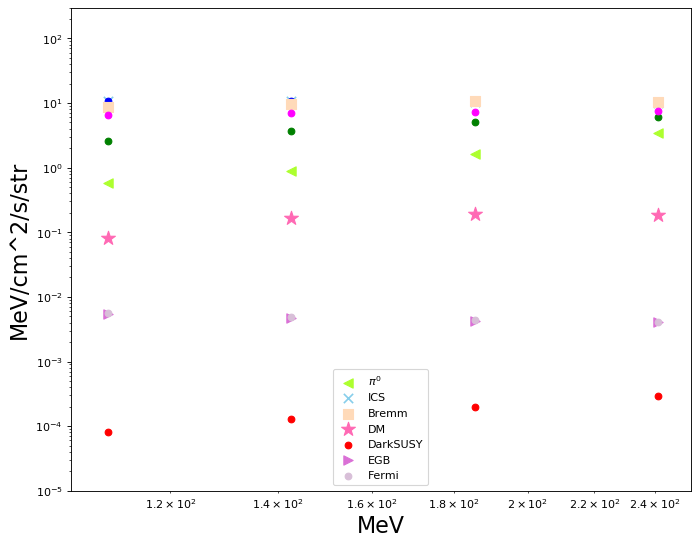

In [49]:
plt.figure(figsize=(10, 8), dpi=80)
fntsz = 20
sizeofdot = 70
norm = 1
range_num = 4
units = deltae_cut[0:range_num]*8500*exposure_time*4*np.pi/196608*.2



cut_energy = energies[3:][0:range_num]
plt.scatter(cut_energy, piflux*cut_energy**2*norm, label = r'$\pi^0$', color = 'greenyellow', s = sizeofdot, marker = '<')
plt.scatter(cut_energy, normals[0][0:range_num]/units*cut_energy**2, color = 'green')
#plt.errorbar(cut_energy, piflux*cut_energy**2, yerr = piflux_err*cut_energy**2, color = 'black', ls = 'none')

plt.scatter(cut_energy, icsflux*cut_energy**2*norm, label = 'ICS', color = 'skyblue', marker = 'x', s = sizeofdot)
plt.scatter(cut_energy, normals[1][0:range_num]/units*cut_energy**2, color = 'blue')
#plt.errorbar(cut_energy, icsflux*cut_energy**2, yerr = icsflux_err*cut_energy**2, color = 'black', ls = 'none')

plt.scatter(cut_energy, bremflux*cut_energy**2*norm, label = 'Bremm', color = 'peachpuff', marker = 's', s = sizeofdot)
plt.scatter(cut_energy, normals[2][0:range_num]/units*cut_energy**2, color = 'magenta')
#plt.errorbar(cut_energy, bremflux*cut_energy**2*norm, yerr = bremflux_err*cut_energy**2, color = 'black', ls = 'none')



plt.scatter(cut_energy, dmflux*cut_energy**2, label = 'DM', color = 'hotpink', marker = '*', s = sizeofdot+100)
#plt.errorbar(cut_energy, dmflux*cut_energy**2, yerr = dmflux_err*cut_energy**2, color = 'black', ls = 'none')
plt.scatter(cut_energy, normals[3][0][0:range_num]/units/.2*cut_energy**2, color = 'red', label = 'DarkSUSY')


plt.scatter(cut_energy, egbflux*cut_energy**2, label = 'EGB', color = 'orchid', marker = '>', s = sizeofdot)
plt.scatter(cut_energy, normals[4][0:range_num]/units*cut_energy**2, color = 'thistle', label = 'Fermi')
#plt.errorbar(cut_energy, egbflux_err*cut_energy**2, yerr = egbflux_err*cut_energy**2, color = 'black', ls = 'none')

plt.ylabel(r'MeV/cm^2/s/str', fontsize=fntsz)
plt.xlabel('MeV', fontsize = fntsz)
#plt.legend(fontsize = 15)
plt.yscale('log')
plt.xscale('log')
#plt.ylim(1e-10, 1e-1)
plt.ylim(1e-5, 3e2)
plt.legend()
#plt.savefig('images/test_w_errors_normalexposure.pdf')


In [12]:
e = readfile(filelist[0])[38].data
energies = np.array(list(e)).T[0]
#cross_sec normalized to 2.2e-26
points = []
errors = []
values = []
fluxes = []
deltae_cut = np.copy(deltae[3:])

In [10]:
for idx in range(3, len(energies)):
#for idx in range(3, range_num+3):
    !python3 ./pymultinest_chains/multinest_marginals.py ./pymultinest_chains/no_psf/chain{idx}/{idx}

model "./pymultinest_chains/no_psf/chain3/3"
  analysing data from ./pymultinest_chains/no_psf/chain3/3.txt
  marginal likelihood:
    ln Z = -5284271481.7 +- 0.2
  parameters:
    a0             -0.90939285197 +- 0.00000000033
    a1             0.002783963586 +- 0.000000000019
    a2             0.12820980626911 +- 0.00000000000097
    a3             3.704773121 +- 0.000000010
    a4             -0.0035038654455 +- 0.0000000000042
creating marginal plot ...
model "./pymultinest_chains/no_psf/chain4/4"
  analysing data from ./pymultinest_chains/no_psf/chain4/4.txt
  marginal likelihood:
    ln Z = -14618876766.8 +- 0.1
  parameters:
    a0             -2.94380063 +- 0.00000025
    a1             0.003808928554 +- 0.000000000045
    a2             0.18388836304 +- 0.00000000010
    a3             3.8842416971 +- 0.0000000030
    a4             -0.006646739955 +- 0.000000000040
creating marginal plot ...
model "./pymultinest_chains/no_psf/chain5/5"
  analysing data from ./pymultinest_ch

model "./pymultinest_chains/no_psf/chain21/21"
  analysing data from ./pymultinest_chains/no_psf/chain21/21.txt
  marginal likelihood:
    ln Z = -3989771837.3 +- 0.2
  parameters:
    a0             -0.400914133449 +- 0.000000000097
    a1             0.04119113061 +- 0.00000000029
    a2             0.48217764980 +- 0.00000000047
    a3             -7.92638305 +- 0.00000011
    a4             -0.0697229551 +- 0.0000000015
creating marginal plot ...
model "./pymultinest_chains/no_psf/chain22/22"
  analysing data from ./pymultinest_chains/no_psf/chain22/22.txt
  marginal likelihood:
    ln Z = -14548774.8 +- 0.1
  parameters:
    a0             -0.01619483568 +- 0.00000000043
    a1             -0.00031293379 +- 0.00000000033
    a2             0.06563722170 +- 0.00000000016
    a3             -1.747197990 +- 0.000000064
    a4             -0.00056354861 +- 0.00000000022
creating marginal plot ...
model "./pymultinest_chains/no_psf/chain23/23"
  analysing data from ./pymultinest_chains

In [32]:
print(normals[0][0:2])

[2.77185807e+13 3.06236117e+13]


In [11]:
'''
Collect the data from the files created
'''

def reverse_norm(arr, norm, deltae, egb = False):
    adjusted_arr = np.array(arr)*np.array(norm)
    counts = adjusted_arr*196608 #counts
    per = counts/(exposure_time*8500*.2) #counts divided by 13 years in seconds /.85m^2/.2
    fin = per/4/np.pi/deltae
    return fin #counts per MeV per sec per str per cm^2

points0 = []
points1 = []
points2 = []
points3 = []
points4 = []
errors0 = []
errors1 = []
errors2 = []
errors3 = []
errors4 = []

f = []
mypath = './pymultinest_chains/no_psf/'
for (dirpath, dirnames, filenames) in walk(mypath):
    f.append(dirnames)
chains_list = f[0]

#for i in range(3, len(energies)):
    #x = (np.loadtxt(MYDIR + '/params' + str(i) + 'stats.dat', skiprows = 4, dtype = 'float', max_rows = 5).T)

# i think i need to go in order of the energies, not just the list of filenames
for number in range(3, len(energies)):
#for number in range(3, range_num+3):
    file = 'chain' + str(number)
    number = re.sub('\D', '', str(file))
    path_to_this_file = mypath + file + '/' + str(number) + 'stats.json'
    f = open(path_to_this_file)
    filehere = json.load(f)
    print(path_to_this_file)
    points0.append(10**(filehere['marginals'][0]['median']))
    points1.append(10**(filehere['marginals'][1]['median']))
    points2.append(10**(filehere['marginals'][2]['median']))
    points3.append(10**(filehere['marginals'][3]['median']))
    points4.append(10**(filehere['marginals'][4]['median']))
    errors0.append(10**(filehere['marginals'][0]['sigma']))
    errors1.append(10**(filehere['marginals'][1]['sigma']))
    errors2.append(10**(filehere['marginals'][2]['sigma']))
    errors3.append(10**(filehere['marginals'][3]['sigma']))
    errors4.append(10**(filehere['marginals'][4]['sigma']))
    
piflux = reverse_norm(points0, normals[0], deltae_cut)
piflux_err = reverse_norm(errors0, normals[0], deltae_cut)
icsflux = reverse_norm(points1, normals[1], deltae_cut)
icsflux_err = reverse_norm(errors1, normals[1], deltae_cut)
bremflux = reverse_norm(points2, normals[2], deltae_cut)
bremflux_err = reverse_norm(errors2, normals[2], deltae_cut)
dmflux = reverse_norm(points3, normals[3][0], deltae_cut)
dmflux_err = reverse_norm(errors3, normals[3][0], deltae_cut)
egbflux = reverse_norm(points4, normals[4], deltae_cut)
egbflux_err = reverse_norm(errors4, normals[4], deltae_cut)
    
'''
piflux = reverse_norm(points0, normals[0][0:range_num], deltae_cut[0:range_num])
piflux_err = reverse_norm(errors0, normals[0][0:range_num], deltae_cut[0:range_num])
icsflux = reverse_norm(points1, normals[1][0:range_num], deltae_cut[0:range_num])
icsflux_err = reverse_norm(errors1, normals[1][0:range_num], deltae_cut[0:range_num])
bremflux = reverse_norm(points2, normals[2][0:range_num], deltae_cut[0:range_num])
bremflux_err = reverse_norm(errors2, normals[2][0:range_num], deltae_cut[0:range_num])
dmflux = reverse_norm(points3, normals[3][0][0:range_num], deltae_cut[0:range_num])
dmflux_err = reverse_norm(errors3, normals[3][0][0:range_num], deltae_cut[0:range_num])
egbflux = reverse_norm(points4, normals[4][0:range_num], deltae_cut[0:range_num])
egbflux_err = reverse_norm(errors4, normals[4][0:range_num], deltae_cut[0:range_num])
'''


./pymultinest_chains/no_psf/chain3/3stats.json
./pymultinest_chains/no_psf/chain4/4stats.json
./pymultinest_chains/no_psf/chain5/5stats.json
./pymultinest_chains/no_psf/chain6/6stats.json
./pymultinest_chains/no_psf/chain7/7stats.json
./pymultinest_chains/no_psf/chain8/8stats.json
./pymultinest_chains/no_psf/chain9/9stats.json
./pymultinest_chains/no_psf/chain10/10stats.json
./pymultinest_chains/no_psf/chain11/11stats.json
./pymultinest_chains/no_psf/chain12/12stats.json
./pymultinest_chains/no_psf/chain13/13stats.json
./pymultinest_chains/no_psf/chain14/14stats.json
./pymultinest_chains/no_psf/chain15/15stats.json
./pymultinest_chains/no_psf/chain16/16stats.json
./pymultinest_chains/no_psf/chain17/17stats.json
./pymultinest_chains/no_psf/chain18/18stats.json
./pymultinest_chains/no_psf/chain19/19stats.json
./pymultinest_chains/no_psf/chain20/20stats.json
./pymultinest_chains/no_psf/chain21/21stats.json
./pymultinest_chains/no_psf/chain22/22stats.json
./pymultinest_chains/no_psf/chain2

'\npiflux = reverse_norm(points0, normals[0][0:range_num], deltae_cut[0:range_num])\npiflux_err = reverse_norm(errors0, normals[0][0:range_num], deltae_cut[0:range_num])\nicsflux = reverse_norm(points1, normals[1][0:range_num], deltae_cut[0:range_num])\nicsflux_err = reverse_norm(errors1, normals[1][0:range_num], deltae_cut[0:range_num])\nbremflux = reverse_norm(points2, normals[2][0:range_num], deltae_cut[0:range_num])\nbremflux_err = reverse_norm(errors2, normals[2][0:range_num], deltae_cut[0:range_num])\ndmflux = reverse_norm(points3, normals[3][0][0:range_num], deltae_cut[0:range_num])\ndmflux_err = reverse_norm(errors3, normals[3][0][0:range_num], deltae_cut[0:range_num])\negbflux = reverse_norm(points4, normals[4][0:range_num], deltae_cut[0:range_num])\negbflux_err = reverse_norm(errors4, normals[4][0:range_num], deltae_cut[0:range_num])\n'

Get error bar plotting
do one at a time, with a 10 year exposure
Try minuit again

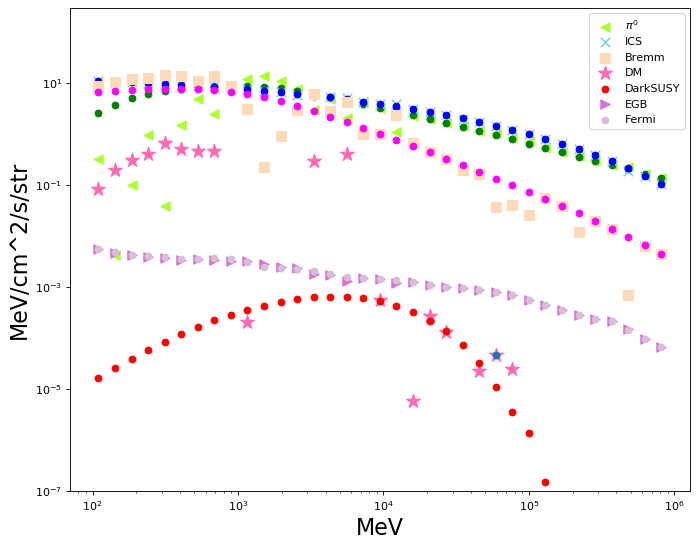

In [15]:
plt.figure(figsize=(10, 8), dpi=80)
fntsz = 20
sizeofdot = 70
norm = 1
units = deltae_cut*8500*exposure_time*4*np.pi/196608*.2
cut_energy = energies[3:]
plt.scatter(cut_energy, piflux*cut_energy**2*norm, label = r'$\pi^0$', color = 'greenyellow', s = sizeofdot, marker = '<')
plt.scatter(cut_energy, normals[0]/units*cut_energy**2, color = 'green')
#plt.errorbar(cut_energy, piflux*cut_energy**2, yerr = piflux_err*cut_energy**2, color = 'black', ls = 'none')

plt.scatter(cut_energy, icsflux*cut_energy**2*norm, label = 'ICS', color = 'skyblue', marker = 'x', s = sizeofdot)
plt.scatter(cut_energy, normals[1]/units*cut_energy**2, color = 'blue')
#plt.errorbar(cut_energy, icsflux*cut_energy**2, yerr = icsflux_err*cut_energy**2, color = 'black', ls = 'none')

plt.scatter(cut_energy, bremflux*cut_energy**2*norm, label = 'Bremm', color = 'peachpuff', marker = 's', s = sizeofdot)
plt.scatter(cut_energy, normals[2]/units*cut_energy**2, color = 'magenta')
#plt.errorbar(cut_energy, bremflux*cut_energy**2*norm, yerr = bremflux_err*cut_energy**2, color = 'black', ls = 'none')



plt.scatter(cut_energy, dmflux*cut_energy**2, label = 'DM', color = 'hotpink', marker = '*', s = sizeofdot+100)
#plt.errorbar(cut_energy, dmflux*cut_energy**2, yerr = dmflux_err*cut_energy**2, color = 'black', ls = 'none')
plt.scatter(cut_energy, normals[3]/units*cut_energy**2, color = 'red', label = 'DarkSUSY')
plt.scatter(cut_energy[24], (dmflux*cut_energy**2)[24])

testidx = 4-3


plt.scatter(cut_energy, egbflux*cut_energy**2, label = 'EGB', color = 'orchid', marker = '>', s = sizeofdot)
plt.scatter(cut_energy, normals[4]/units*cut_energy**2, color = 'thistle', label = 'Fermi')
#plt.errorbar(cut_energy, egbflux_err*cut_energy**2, yerr = egbflux_err*cut_energy**2, color = 'black', ls = 'none')

plt.ylabel(r'MeV/cm^2/s/str', fontsize=fntsz)
plt.xlabel('MeV', fontsize = fntsz)
#plt.legend(fontsize = 15)
plt.yscale('log')
plt.xscale('log')
#plt.ylim(1e-10, 1e-1)
plt.ylim(1e-7, 3e2)
plt.legend()
plt.savefig('images/test_w_errors_normalexposure.pdf')


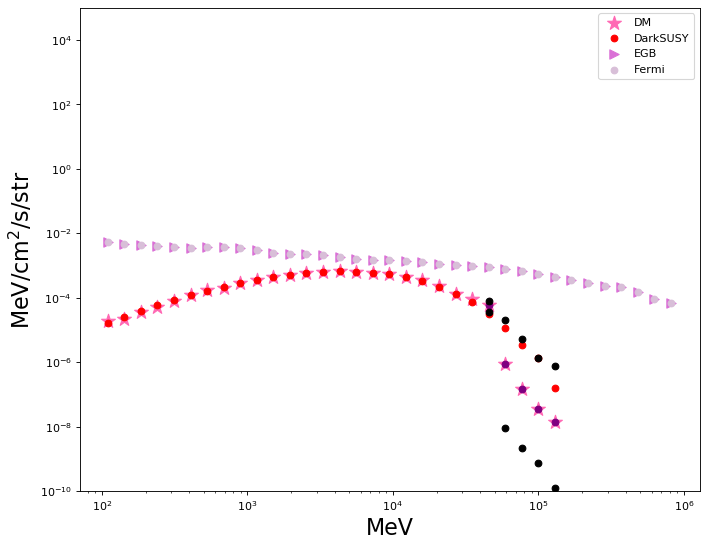

In [43]:
#DM Plot

plt.figure(figsize=(10, 8), dpi=80)
fntsz = 20
sizeofdot = 70
norm = 1
units = deltae_cut*8500*exposure_time*4*np.pi/196608*.2
cut_energy = energies[3:]

plt.scatter(cut_energy, dmflux*cut_energy**2, label = 'DM', color = 'hotpink', marker = '*', s = sizeofdot+100)
#plt.errorbar(cut_energy, dmflux*cut_energy**2, yerr = dmflux_err*cut_energy**2, color = 'black', ls = 'none')
plt.scatter(cut_energy, normals[3]/units*cut_energy**2, color = 'red', label = 'DarkSUSY')

testidx = 26-3

plt.scatter(cut_energy[testidx], (dmflux*cut_energy**2)[testidx], color = 'purple')
plt.scatter(cut_energy[testidx], reverse_norm(10**0.045410026519565674, normals[3][0][testidx], deltae_cut[testidx])*(cut_energy**2)[testidx], color = 'black')
plt.scatter(cut_energy[testidx], reverse_norm(10**(0.38876142744420217), normals[3][0][testidx], deltae_cut[testidx])*(cut_energy**2)[testidx], color = 'black')


testidx = 27-3

plt.scatter(cut_energy[testidx], (dmflux*cut_energy**2)[testidx], color = 'purple')
plt.scatter(cut_energy[testidx], reverse_norm(10**-3.093127021536, normals[3][0][testidx], deltae_cut[testidx])*(cut_energy**2)[testidx], color = 'black')
plt.scatter(cut_energy[testidx], reverse_norm(10**(0.2523578191600389), normals[3][0][testidx], deltae_cut[testidx])*(cut_energy**2)[testidx], color = 'black')


testidx = 28-3

plt.scatter(cut_energy[testidx], (dmflux*cut_energy**2)[testidx], color = 'purple')
plt.scatter(cut_energy[testidx], reverse_norm(10**-3.196395018912308, normals[3][0][testidx], deltae_cut[testidx])*(cut_energy**2)[testidx], color = 'black')
plt.scatter(cut_energy[testidx], reverse_norm(10**(0.18769879572772344), normals[3][0][testidx], deltae_cut[testidx])*(cut_energy**2)[testidx], color = 'black')

testidx = 29-3

plt.scatter(cut_energy[testidx], (dmflux*cut_energy**2)[testidx], color = 'purple')
plt.scatter(cut_energy[testidx], reverse_norm(10**-3.249601774310395, normals[3][0][testidx], deltae_cut[testidx])*(cut_energy**2)[testidx], color = 'black')
plt.scatter(cut_energy[testidx], reverse_norm(10**(0.010225651091986246), normals[3][0][testidx], deltae_cut[testidx])*(cut_energy**2)[testidx], color = 'black')

testidx = 30-3

plt.scatter(cut_energy[testidx], (dmflux*cut_energy**2)[testidx], color = 'purple')
plt.scatter(cut_energy[testidx], reverse_norm(10**-3.107930783280113, normals[3][0][testidx], deltae_cut[testidx])*(cut_energy**2)[testidx], color = 'black')
plt.scatter(cut_energy[testidx], reverse_norm(10**(0.6811981981114344), normals[3][0][testidx], deltae_cut[testidx])*(cut_energy**2)[testidx], color = 'black')

plt.scatter(cut_energy, egbflux*cut_energy**2, label = 'EGB', color = 'orchid', marker = '>', s = sizeofdot)
plt.scatter(cut_energy, normals[4]/units*cut_energy**2, color = 'thistle', label = 'Fermi')
#plt.errorbar(cut_energy, egbflux*cut_energy**2, yerr = egbflux_err*cut_energy**2, color = 'black', ls = 'none')


#plt.scatter(cut_energy[testidx], reverse_norm(10**3.3652186356967255, normals[3][0][testidx], deltae_cut[testidx])*cut_energy[testidx]**2, color = 'green')
#plt.scatter(cut_energy[testidx], reverse_norm(10**3.5926827779668318, normals[3][0][testidx], deltae_cut[testidx])*cut_energy[testidx]**2, color = 'green')

plt.ylabel(r'MeV/cm$^2$/s/str', fontsize=fntsz)
plt.xlabel('MeV', fontsize = fntsz)
#plt.text(1e2, 5e-3, 'exposure time: {} s'.format(exposure_time), fontsize=12)
#plt.legend(fontsize = 15)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-10, 1e5)
#plt.ylim(1e-1, 3e1)
plt.legend()
#plt.savefig('images/dm_w_error_normalexposure.pdf')

#EGB flux Plot



#plt.savefig('images/egb_w_error_highexposure.pdf')



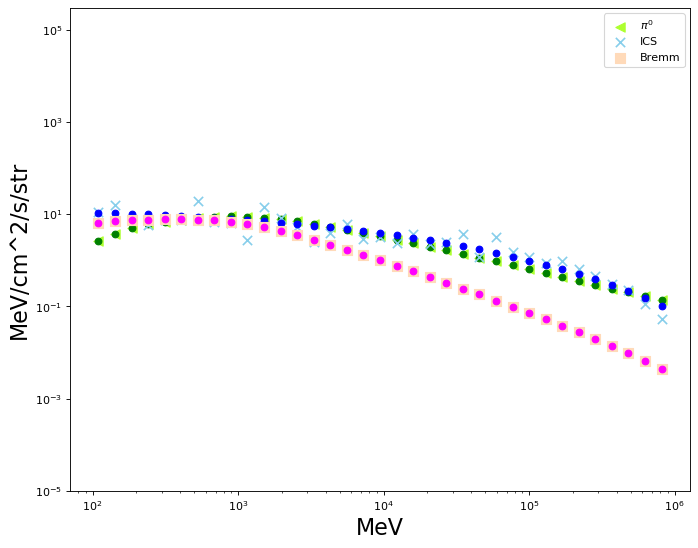

In [12]:
#3 plot

plt.figure(figsize=(10, 8), dpi=80)
fntsz = 20
sizeofdot = 70
norm = 1
units = deltae_cut*8500*exposure_time*4*np.pi/196608*.2
cut_energy = energies[3:]
plt.scatter(cut_energy, piflux*cut_energy**2*norm, label = r'$\pi^0$', color = 'greenyellow', s = sizeofdot, marker = '<')
plt.scatter(cut_energy, normals[0]/units*cut_energy**2, color = 'green')
#plt.errorbar(cut_energy, piflux*cut_energy**2, yerr = piflux_err*cut_energy**2, color = 'black', ls = 'none')

plt.scatter(cut_energy, icsflux*cut_energy**2*norm, label = 'ICS', color = 'skyblue', marker = 'x', s = sizeofdot)
plt.scatter(cut_energy, normals[1]/units*cut_energy**2, color = 'blue')
#plt.errorbar(cut_energy, icsflux*cut_energy**2, yerr = icsflux_err*cut_energy**2, color = 'black', ls = 'none')

plt.scatter(cut_energy, bremflux*cut_energy**2*norm, label = 'Bremm', color = 'peachpuff', marker = 's', s = sizeofdot)
plt.scatter(cut_energy, normals[2]/units*cut_energy**2, color = 'magenta')
#plt.errorbar(cut_energy, bremflux*cut_energy**2*norm, yerr = bremflux_err*cut_energy**2, color = 'black', ls = 'none')



plt.ylabel(r'MeV/cm^2/s/str', fontsize=fntsz)
plt.xlabel('MeV', fontsize = fntsz)
#plt.legend(fontsize = 15)
plt.yscale('log')
plt.xscale('log')
#plt.ylim(1e-10, 1e-1)
plt.ylim(1e-5, 3e5)
plt.legend()
#plt.savefig('images/test_w_errors_normalexposure.pdf')


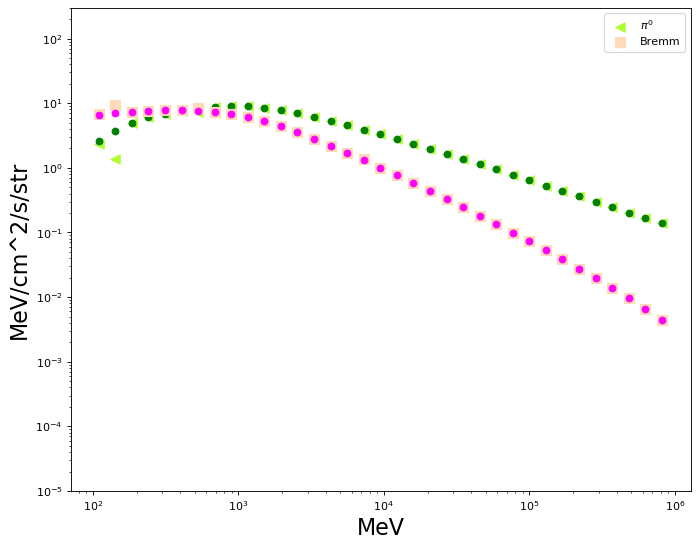

In [12]:
#pi bremm plot

plt.figure(figsize=(10, 8), dpi=80)
fntsz = 20
sizeofdot = 70
norm = 1
units = deltae_cut*8500*exposure_time*4*np.pi/196608*.2
cut_energy = energies[3:]
plt.scatter(cut_energy, piflux*cut_energy**2*norm, label = r'$\pi^0$', color = 'greenyellow', s = sizeofdot, marker = '<')
plt.scatter(cut_energy, normals[0]/units*cut_energy**2, color = 'green')
#plt.errorbar(cut_energy, piflux*cut_energy**2, yerr = piflux_err*cut_energy**2, color = 'black', ls = 'none')


plt.scatter(cut_energy, bremflux*cut_energy**2*norm, label = 'Bremm', color = 'peachpuff', marker = 's', s = sizeofdot)
plt.scatter(cut_energy, normals[2]/units*cut_energy**2, color = 'magenta')
#plt.errorbar(cut_energy, bremflux*cut_energy**2*norm, yerr = bremflux_err*cut_energy**2, color = 'black', ls = 'none')



plt.ylabel(r'MeV/cm^2/s/str', fontsize=fntsz)
plt.xlabel('MeV', fontsize = fntsz)
#plt.legend(fontsize = 15)
plt.yscale('log')
plt.xscale('log')
#plt.ylim(1e-10, 1e-1)
plt.ylim(1e-5, 3e2)
plt.legend()
#plt.savefig('images/test_w_errors_normalexposure.pdf')


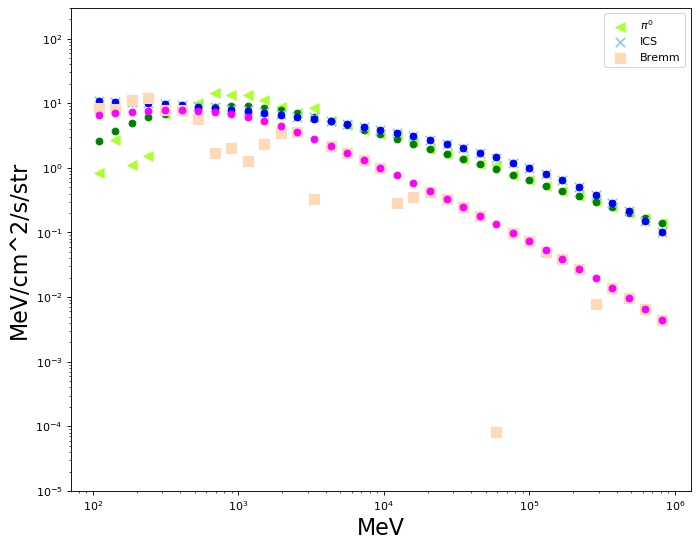

In [15]:
#3 plot

plt.figure(figsize=(10, 8), dpi=80)
fntsz = 20
sizeofdot = 70
norm = 1
units = deltae_cut*8500*exposure_time*4*np.pi/196608*.2
cut_energy = energies[3:]
plt.scatter(cut_energy, piflux*cut_energy**2*norm, label = r'$\pi^0$', color = 'greenyellow', s = sizeofdot, marker = '<')
plt.scatter(cut_energy, normals[0]/units*cut_energy**2, color = 'green')
#plt.errorbar(cut_energy, piflux*cut_energy**2, yerr = piflux_err*cut_energy**2, color = 'black', ls = 'none')

plt.scatter(cut_energy, icsflux*cut_energy**2*norm, label = 'ICS', color = 'skyblue', marker = 'x', s = sizeofdot)
plt.scatter(cut_energy, normals[1]/units*cut_energy**2, color = 'blue')
#plt.errorbar(cut_energy, icsflux*cut_energy**2, yerr = icsflux_err*cut_energy**2, color = 'black', ls = 'none')

plt.scatter(cut_energy, bremflux*cut_energy**2*norm, label = 'Bremm', color = 'peachpuff', marker = 's', s = sizeofdot)
plt.scatter(cut_energy, normals[2]/units*cut_energy**2, color = 'magenta')
#plt.errorbar(cut_energy, bremflux*cut_energy**2*norm, yerr = bremflux_err*cut_energy**2, color = 'black', ls = 'none')



plt.ylabel(r'MeV/cm^2/s/str', fontsize=fntsz)
plt.xlabel('MeV', fontsize = fntsz)
#plt.legend(fontsize = 15)
plt.yscale('log')
plt.xscale('log')
#plt.ylim(1e-10, 1e-1)
plt.ylim(1e-5, 3e2)
plt.legend()
#plt.savefig('images/test_w_errors_normalexposure.pdf')


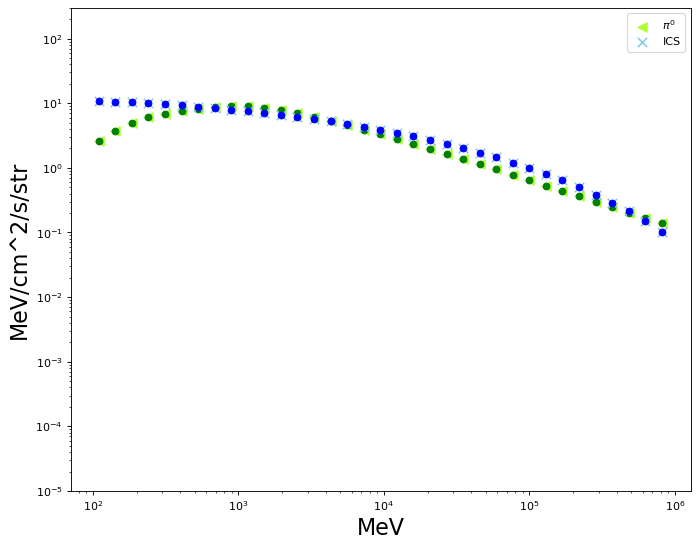

In [13]:
#ics + pi

plt.figure(figsize=(10, 8), dpi=80)
fntsz = 20
sizeofdot = 70
norm = 1
units = deltae_cut*8500*exposure_time*4*np.pi/196608*.2
cut_energy = energies[3:]
plt.scatter(cut_energy, piflux*cut_energy**2*norm, label = r'$\pi^0$', color = 'greenyellow', s = sizeofdot, marker = '<')
plt.scatter(cut_energy, normals[0]/units*cut_energy**2, color = 'green')
#plt.errorbar(cut_energy, piflux*cut_energy**2, yerr = piflux_err*cut_energy**2, color = 'black', ls = 'none')

plt.scatter(cut_energy, icsflux*cut_energy**2*norm, label = 'ICS', color = 'skyblue', marker = 'x', s = sizeofdot)
plt.scatter(cut_energy, normals[1]/units*cut_energy**2, color = 'blue')
#plt.errorbar(cut_energy, icsflux*cut_energy**2, yerr = icsflux_err*cut_energy**2, color = 'black', ls = 'none')




plt.ylabel(r'MeV/cm^2/s/str', fontsize=fntsz)
plt.xlabel('MeV', fontsize = fntsz)
#plt.legend(fontsize = 15)
plt.yscale('log')
plt.xscale('log')
#plt.ylim(1e-10, 1e-1)
plt.ylim(1e-5, 3e2)
plt.legend()
#plt.savefig('images/test_w_errors_normalexposure.pdf')


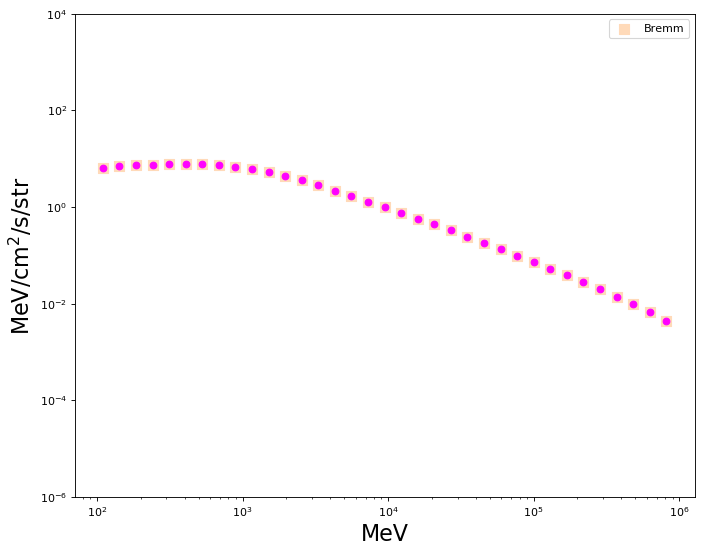

In [14]:
#Brem flux Plot

plt.figure(figsize=(10, 8), dpi=80)
fntsz = 20
sizeofdot = 70
norm = 1
units = deltae_cut*8500*exposure_time*4*np.pi/196608*.2
cut_energy = energies[3:]

plt.scatter(cut_energy, bremflux*cut_energy**2*norm, label = 'Bremm', color = 'peachpuff', marker = 's', s = sizeofdot)
plt.scatter(cut_energy, normals[2]/units*cut_energy**2, color = 'magenta')
#plt.errorbar(cut_energy, bremflux*cut_energy**2*norm, yerr = bremflux_err*cut_energy**2, color = 'black', ls = 'none')
#plt.scatter(cut_energy[23], (bremflux*cut_energy**2*norm)[23], color = 'red')

plt.ylabel(r'MeV/cm$^2$/s/str', fontsize=fntsz)
plt.xlabel('MeV', fontsize = fntsz)
#plt.text(1e2, 2e-6, 'exposure time: {} s'.format(exposure_time), fontsize=12)
#plt.legend(fontsize = 15)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-6, 1e4)
#plt.ylim(1e-1, 3e1)
plt.legend()
#plt.savefig('images/brem_w_error_normalexposure.pdf')


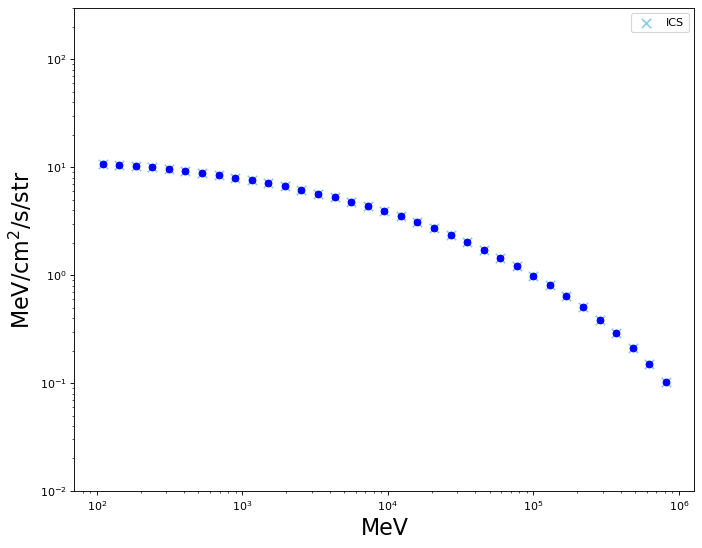

In [12]:
#ICS flux plot


plt.figure(figsize=(10, 8), dpi=80)
fntsz = 20
sizeofdot = 70
norm = 1
units = deltae_cut*8500*exposure_time*4*np.pi/196608*.2
cut_energy = energies[3:]

plt.scatter(cut_energy, icsflux*cut_energy**2*norm, label = 'ICS', color = 'skyblue', marker = 'x', s = sizeofdot)
plt.scatter(cut_energy, normals[1]/units*cut_energy**2, color = 'blue')
#plt.errorbar(cut_energy, icsflux*cut_energy**2, yerr = icsflux_err*cut_energy**2, color = 'black', ls = 'none')

plt.ylabel(r'MeV/cm$^2$/s/str', fontsize=fntsz)
plt.xlabel('MeV', fontsize = fntsz)
#plt.text(1e2, 2e-6, 'exposure time: {} s'.format(exposure_time), fontsize=12)
#plt.legend(fontsize = 15)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-2, 3e2)
#plt.ylim(1e-1, 3e1)
plt.legend()
#plt.savefig('images/ics_w_error_normalexposure.pdf')


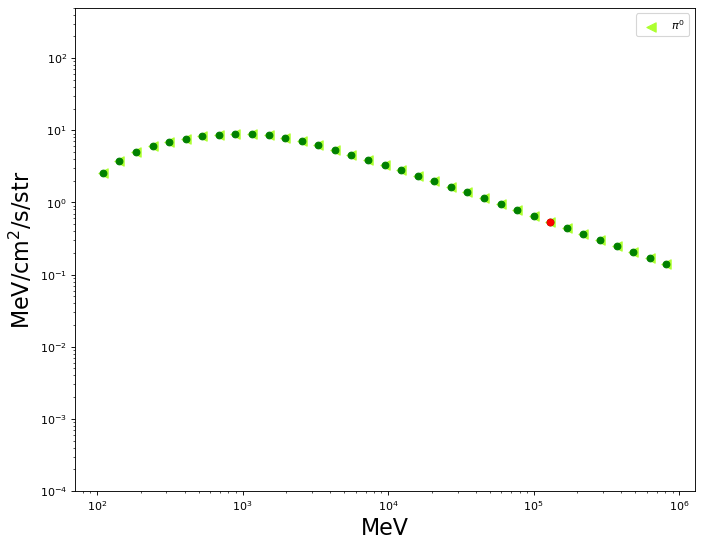

In [12]:
#Pi flux Plot

plt.figure(figsize=(10, 8), dpi=80)
fntsz = 20
sizeofdot = 70
norm = 1
units = deltae_cut*8500*exposure_time*4*np.pi/196608*.2
cut_energy = energies[3:]

plt.scatter(cut_energy, piflux*cut_energy**2*norm, label = r'$\pi^0$', color = 'greenyellow', s = sizeofdot, marker = '<')
plt.scatter(cut_energy, normals[0]/units*cut_energy**2, color = 'green')
#plt.errorbar(cut_energy, piflux*cut_energy**2, yerr = piflux_err*cut_energy**2, color = 'black', ls = 'none')

plt.scatter(cut_energy[27], (piflux*cut_energy**2*norm)[27], color = 'red')
plt.ylabel(r'MeV/cm$^2$/s/str', fontsize=fntsz)
plt.xlabel('MeV', fontsize = fntsz)
#plt.text(1e2, 9.3e0, 'exposure time: {} s'.format(exposure_time), fontsize=12)
#plt.legend(fontsize = 15)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-4, 5e2)
#plt.ylim(1e-1, 3e1)
plt.legend()
#plt.savefig('images/pi_w_error_normalexposure.pdf')


In [ ]:
#3 plot

plt.figure(figsize=(10, 8), dpi=80)
fntsz = 20
sizeofdot = 70
norm = 1
units = deltae_cut*8500*exposure_time*4*np.pi/196608*.2
cut_energy = energies[3:]
plt.scatter(cut_energy, piflux*cut_energy**2*norm, label = r'$\pi^0$', color = 'greenyellow', s = sizeofdot, marker = '<')
plt.scatter(cut_energy, normals[0]/units*cut_energy**2, color = 'green')
#plt.errorbar(cut_energy, piflux*cut_energy**2, yerr = piflux_err*cut_energy**2, color = 'black', ls = 'none')

plt.scatter(cut_energy, icsflux*cut_energy**2*norm, label = 'ICS', color = 'skyblue', marker = 'x', s = sizeofdot)
plt.scatter(cut_energy, normals[1]/units*cut_energy**2, color = 'blue')
#plt.errorbar(cut_energy, icsflux*cut_energy**2, yerr = icsflux_err*cut_energy**2, color = 'black', ls = 'none')

plt.scatter(cut_energy, bremflux*cut_energy**2*norm, label = 'Bremm', color = 'peachpuff', marker = 's', s = sizeofdot)
plt.scatter(cut_energy, normals[2]/units*cut_energy**2, color = 'magenta')
#plt.errorbar(cut_energy, bremflux*cut_energy**2*norm, yerr = bremflux_err*cut_energy**2, color = 'black', ls = 'none')



plt.ylabel(r'MeV/cm^2/s/str', fontsize=fntsz)
plt.xlabel('MeV', fontsize = fntsz)
#plt.legend(fontsize = 15)
plt.yscale('log')
plt.xscale('log')
#plt.ylim(1e-10, 1e-1)
plt.ylim(1e-5, 3e2)
plt.legend()
#plt.savefig('images/test_w_errors_normalexposure.pdf')


In [ ]:
#DM Plot

plt.figure(figsize=(10, 8), dpi=80)
fntsz = 20
sizeofdot = 70
norm = 1
units = deltae_cut*8500*exposure_time*4*np.pi/196608*.2
cut_energy = energies[3:]

plt.scatter(cut_energy, dmflux*cut_energy**2, label = 'DM', color = 'hotpink', marker = '*', s = sizeofdot+100)
#plt.errorbar(cut_energy, dmflux*cut_energy**2, yerr = dmflux_err*cut_energy**2, color = 'black', ls = 'none')
plt.scatter(cut_energy, normals[0]/units*cut_energy**2, color = 'red', label = 'DarkSUSY')
testidx = 3

#plt.scatter(cut_energy[testidx], reverse_norm(10**3.3652186356967255, normals[3][0][testidx], deltae_cut[testidx])*cut_energy[testidx]**2, color = 'green')
#plt.scatter(cut_energy[testidx], reverse_norm(10**3.5926827779668318, normals[3][0][testidx], deltae_cut[testidx])*cut_energy[testidx]**2, color = 'green')

plt.ylabel(r'MeV/cm$^2$/s/str', fontsize=fntsz)
plt.xlabel('MeV', fontsize = fntsz)
#plt.text(1e2, 5e-3, 'exposure time: {} s'.format(exposure_time), fontsize=12)
#plt.legend(fontsize = 15)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-10, 1e3)
#plt.ylim(1e-1, 3e1)
plt.legend()
#plt.savefig('images/dm_w_error_normalexposure.pdf')


In [ ]:
#EGB flux Plot

plt.figure(figsize=(10, 8), dpi=80)
fntsz = 20
sizeofdot = 70
norm = 1
units = deltae_cut*8500*exposure_time*4*np.pi/196608*.2
cut_energy = energies[3:]

plt.scatter(cut_energy, egbflux*cut_energy**2, label = 'EGB', color = 'orchid', marker = '>', s = sizeofdot)
plt.scatter(cut_energy, normals/units*cut_energy**2, color = 'thistle', label = 'Fermi')
#plt.errorbar(cut_energy, egbflux*cut_energy**2, yerr = egbflux_err*cut_energy**2, color = 'black', ls = 'none')

plt.ylabel(r'MeV/cm$^2$/s/str', fontsize=fntsz)
plt.xlabel('MeV', fontsize = fntsz)
#plt.text(1e2, 7e-3, 'exposure time: {} s'.format(exposure_time), fontsize=12)
#plt.legend(fontsize = 15)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-6, 1e-1)
#plt.ylim(1e-1, 3e1)
plt.legend()
#plt.savefig('images/egb_w_error_highexposure.pdf')
